In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, r2_score
# from sklearn.cluster import KMeans
from xgboost import XGBRegressor
import seaborn as sns

In [421]:
df = pd.read_csv('Data/RedfinDataReadyData3.csv')

In [423]:
df.head()

,SALE TYPE,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,Waterfront,Privatepool,...,STATUS,NEXT OPEN HOUSE START TIME,NEXT OPEN HOUSE END TIME,URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING),SOURCE,MLS#,FAVORITE,INTERESTED,LATITUDE,LONGITUDE
0,PAST SALE,June-30-2025,Single Family Residential,4754 Ocean Blvd,Destin,FL,32541,6200000,1,1,...,Sold,NaN,NaN,https://www.redfin.com/FL/Destin/4754-Ocean-Bl...,ECAR,970625,N,Y,30.379933,-86.402693
1,PAST SALE,March-3-2025,Single Family Residential,85 Woodward St,Destin,FL,32541,5750000,1,1,...,Sold,NaN,NaN,https://www.redfin.com/FL/Destin/85-Woodward-S...,ECAR,961837,N,Y,30.384326,-86.426857
2,PAST SALE,July-10-2025,Single Family Residential,4518 Olde Plantation Pl,Destin,FL,32541,5500000,1,1,...,Sold,NaN,NaN,https://www.redfin.com/FL/Destin/4518-Olde-Pla...,ECAR,978618,N,Y,30.403697,-86.448623
3,PAST SALE,March-12-2025,Single Family Residential,400 Coleman Pt,Destin,FL,32541,5500000,1,1,...,Sold,NaN,NaN,https://www.redfin.com/FL/Destin/400-Coleman-P...,ECAR,963288,N,Y,30.408020,-86.441491
4,PAST SALE,May-30-2025,Single Family Residential,621 Calhoun Ave,Destin,FL,32541,4630000,1,1,...,Sold,NaN,NaN,https://www.redfin.com/FL/Destin/621-Calhoun-A...,ECAR,971824,N,Y,30.412671,-86.497020


In [425]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 29 columns):
 #   Column                                                                                       Non-Null Count  Dtype  
---  ------                                                                                       --------------  -----  
 0   SALE TYPE                                                                                    173 non-null    object 
 1   SOLD DATE                                                                                    165 non-null    object 
 2   PROPERTY TYPE                                                                                173 non-null    object 
 3   ADDRESS                                                                                      173 non-null    object 
 4   CITY                                                                                         173 non-null    object 
 5   STATE OR PROVINCE                   

In [427]:
df.groupby('PROPERTY TYPE')['PRICE'].describe()

,count,mean,std,min,25%,50%,75%,max
PROPERTY TYPE,,,,,,,,
Single Family Residential,173.0,1.234826e+06,1.065591e+06,285000.0,575000.0,850000.0,1575000.0,6200000.0


#### Mean: SFR - $1,234,826 or 1.234826e+06  

* From Nvidia website: XGBoost is an open-source software library that implements optimized distributed gradient boosting machine learning algorithms under the Gradient Boosting framework. XGBoost, which stands for Extreme Gradient Boosting, is a scalable, distributed gradient-boosted decision tree (GBDT) machine learning library. It provides parallel tree boosting and is the leading machine learning library for regression, classification, and ranking problems.

### XGBoost Regressor to determine the sales price.

#### Function: A reusable block of code that performs a task.

#### Method: A function that belongs to an object, like a DataFrame, series, or string. It's called with dot notation.

* Function print(), mean_absolute_error() Standalone code block that returns a result.

* Method df.copy(), df.to_csv() Called on objects using dot notation.

* Model Methods xgb.fit(), xgb.predict() Functions tied to Machine Learning model objects.

* pd.concat()	Function	Called from the module, not tied to any DataFrame

* xgb.fit()	Method	Called on an object (xgb) that is an instance of a class

* If it's called on an object, and it's defined inside a class, it's a method.

* If it's called from a module, like pd, np, or sklearn, and doesn’t rely on a specific instance, it’s a function.

In [433]:
# Updated feature columns including the new cluster
features = ['BEDS', 'BATHS', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT', 'Waterfront', 'Privatepool',
            'HOA/MONTH', 'LATITUDE', 'LONGITUDE', 'ZIP OR POSTAL CODE']

# Function to train and predict for a specific property type
def train_and_predict(property_type, features):
    # Filter data for the specific property type
    property_data = df[df['PROPERTY TYPE'] == property_type].copy()

    if property_data.empty:
        print(f"No data found for PROPERTY TYPE: {property_type}")
        return pd.DataFrame()

    # Prepare features and target
    X = property_data[features].fillna(0)
    y = property_data['PRICE'].fillna(0)

    # Reset indices to preserve alignment
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    property_data = property_data.reset_index(drop=True)

    # Split the data
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, property_data.index, test_size=0.2, random_state=42
    )

    # Mark the data split
    property_data.loc[idx_train, 'Data Split'] = 'Train'
    property_data.loc[idx_test, 'Data Split'] = 'Test'

    # Train XGBoost model
    xgb = XGBRegressor(
        n_estimators=150,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bynode=0.8,
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=42
    )
    # reg:absoluteerror' means the model optimizes for Mean Absolute Error (MAE), aligning with the goal of predicting prices accurately in terms of absolute differences.
    # Limits the maximum depth of each tree to 3, controlling model complexity to prevent overfitting by restricting how deep trees can grow.
    # Also known as eta, this scales the contribution of each tree; a value of 0.1 means each tree’s contribution is shrunk by 10%, encouraging gradual learning to improve generalization.
    # Uses 80% of the data to grow each tree, introducing randomness to reduce overfitting by training on a subset of rows.
    # Uses 80% of features at each node split, adding randomness to feature selection to reduce overfitting and improve robustness.
    # L1 regularization (Lasso) term on weights; a small value (0.1) encourages sparsity in feature usage, helping to prevent overfitting.
    # L2 regularization (Ridge) term on weights; a value of 1 adds a penalty to large weights, further helping to prevent overfitting.
    # Sets a seed for reproducibility, ensuring the same random splits and results each time the code is run.
    xgb.fit(X_train, y_train)

    # Predict on train/test
    y_pred_train = xgb.predict(X_train)
    y_pred_test = xgb.predict(X_test)

    # Print MAE
    print(f"\n{property_type} - Training MAE: {mean_absolute_error(y_train, y_pred_train):,.0f}")
    print(f"{property_type} - Testing MAE: {mean_absolute_error(y_test, y_pred_test):,.0f}")

    # Feature importances
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': xgb.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    print(f"\n{property_type} - Feature Importances:")
    print(importance_df)

    # Add prediction column
    property_data['PredictedPrice'] = xgb.predict(X)

    return property_data[['ADDRESS', 'Data Split', 'PROPERTY TYPE', 'PredictedPrice', 'PRICE']]

# Filter property types with at least 2 listings
valid_types = df['PROPERTY TYPE'].value_counts()
valid_types = valid_types[valid_types >= 2].index

# Run model for each property type
all_predictions_list = []

for property_type in valid_types:
    prediction_df = train_and_predict(property_type, features)
    if not prediction_df.empty:
        all_predictions_list.append(prediction_df)

# Combine and round predictions
all_predictions = pd.concat(all_predictions_list, ignore_index=True).round(0)

# Export to CSV
output_path = "Data/Redfin_PropertyType_XGB.csv"
all_predictions[['ADDRESS', 'Data Split', 'PROPERTY TYPE', 'PredictedPrice', 'PRICE']].to_csv(output_path, index=False)


Single Family Residential - Training MAE: 51,256
Single Family Residential - Testing MAE: 233,082

Single Family Residential - Feature Importances:
               Feature  Importance
5           Waterfront    0.276875
1                BATHS    0.241227
2          SQUARE FEET    0.215443
6          Privatepool    0.059835
8             LATITUDE    0.056809
0                 BEDS    0.056144
4           YEAR BUILT    0.035624
3             LOT SIZE    0.025372
7            HOA/MONTH    0.018199
9            LONGITUDE    0.014472
10  ZIP OR POSTAL CODE    0.000000


* Tree complexity control:
max_depth=3: Shallow trees generalize better, avoiding deep overfit structures.

* Gradual learning:
learning_rate=0.1: Slows learning so the model doesn’t jump to conclusions too fast.

* Randomness in sampling:
subsample=0.8: Each tree is trained on only 80% of the rows → reduces variance, introduces randomness.

* colsample_bynode=0.8: Each node in a tree uses 80% of features → adds diversity across trees.

* Regularization: reg_alpha=0.1: L1 regularization = pushes some features out entirely. reg_lambda=1: L2 regularization = discourages large weights in leaf nodes.

In [436]:
# Evaluate R² and MAE by position
# We start with an empty list that then becomes a list of data dictionaries
position_metrics = []

# Iterates over each unique property type present in the predictions.
# subset - Filters the full prediction DataFrame to only include rows of the current property type.
for pos in all_predictions['PROPERTY TYPE'].unique():
    subset = all_predictions[all_predictions['PROPERTY TYPE'] == pos]
    r2 = r2_score(subset['PRICE'], subset['PredictedPrice'])
    mae = mean_absolute_error(subset['PRICE'], subset['PredictedPrice'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nPerformance Metrics by Position:")
print(position_metrics_df)


Performance Metrics by Position:
                    Position    R²       MAE
0  Single Family Residential  0.98  88041.82


In [438]:
# Filter to test set only
test_only = all_predictions[all_predictions['Data Split'] == 'Test']

# Evaluate R² and MAE by position using only the test data
position_metrics = []
# Iterates over each unique property type present in the predictions.
# subset - Filters the full prediction DataFrame to only include rows of the current property type.
for pos in test_only['PROPERTY TYPE'].unique():
    subset = test_only[test_only['PROPERTY TYPE'] == pos]
    r2 = r2_score(subset['PRICE'], subset['PredictedPrice'])
    mae = mean_absolute_error(subset['PRICE'], subset['PredictedPrice'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nPerformance Metrics by Position (Test Set Only):")
print(position_metrics_df)


Performance Metrics by Position (Test Set Only):
                    Position     R²        MAE
0  Single Family Residential  0.852  233081.66


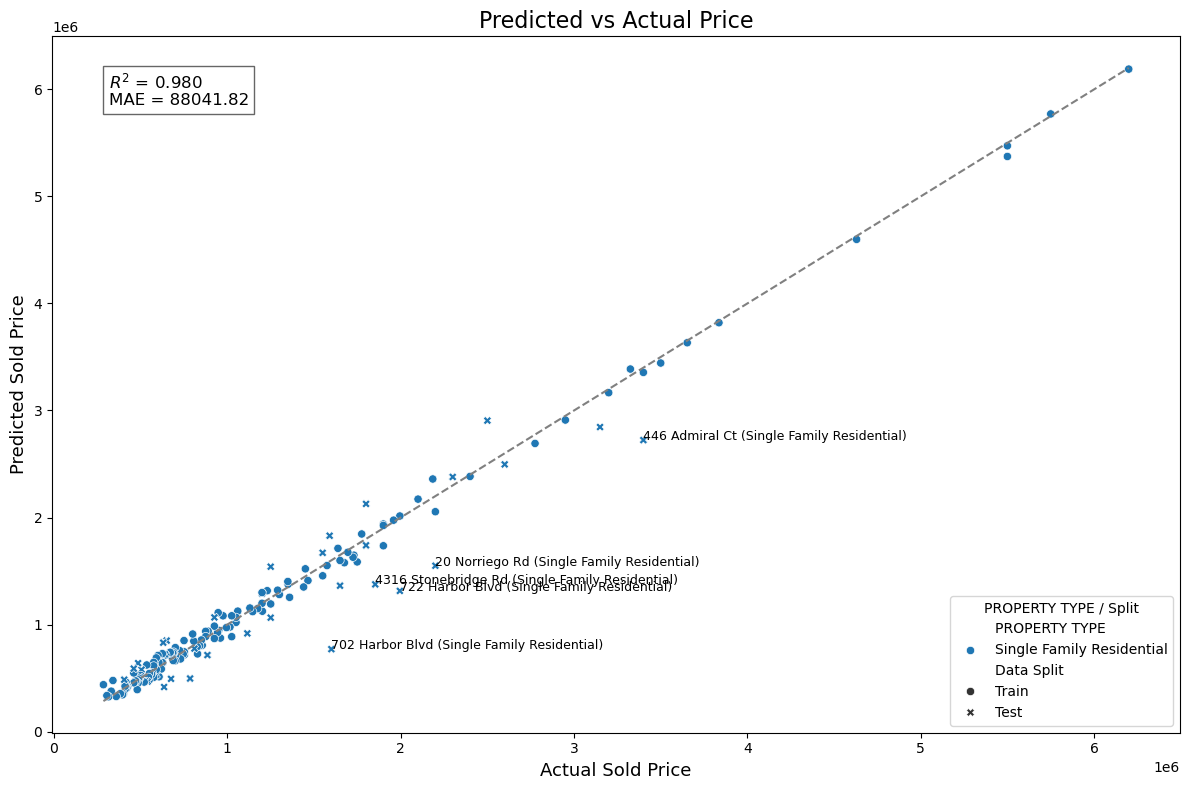

In [440]:
# Calculate metrics
r2 = r2_score(all_predictions['PRICE'], all_predictions['PredictedPrice'])
mae = mean_absolute_error(all_predictions['PRICE'], all_predictions['PredictedPrice'])

# Calculate residuals
all_predictions['Residual'] = np.abs(all_predictions['PRICE'] - all_predictions['PredictedPrice'])

# Get top 5 outliers
top_outliers = all_predictions.nlargest(5, 'Residual')

# Plotting
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=all_predictions,
    x='PRICE',
    y='PredictedPrice',
    hue='PROPERTY TYPE',
    style='Data Split',
    palette='tab10',
)

# Diagonal line for reference (perfect prediction)
min_val = min(all_predictions['PRICE'].min(), all_predictions['PredictedPrice'].min())
max_val = max(all_predictions['PRICE'].max(), all_predictions['PredictedPrice'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color='gray')

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['PRICE'] + 2, row['PredictedPrice'],
             f"{row['ADDRESS']} ({row['PROPERTY TYPE']})", fontsize=9, color='black')

# Labels and title
plt.title('Predicted vs Actual Price', fontsize=16)
plt.xlabel('Actual Sold Price', fontsize=13)
plt.ylabel('Predicted Sold Price', fontsize=13)

# Get the current axes
ax = plt.gca()

# Display R² and MAE in the top left using axes coordinates
plt.text(0.05, 0.95,  # Top left corner
         f"$R^2$ = {r2:.3f}\nMAE = {mae:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6),
         transform=ax.transAxes,  # Use axes coordinates
         verticalalignment='top', horizontalalignment='left')

# Legend and layout
plt.legend(title='PROPERTY TYPE / Split', loc='lower right')
plt.tight_layout()
plt.show()

In [442]:
all_predictions['ValuationDiff'] = all_predictions['PredictedPrice'] - all_predictions['PRICE']

In [444]:
overvalued = all_predictions.sort_values(by='ValuationDiff', ascending=False).head(10)
print("Most Over-Valued Properties:")
print(overvalued[['ADDRESS', 'Data Split', 'PROPERTY TYPE', 'PRICE', 'PredictedPrice', 'ValuationDiff']])

Most Over-Valued Properties:
                         ADDRESS Data Split              PROPERTY TYPE  \
16                 103 Shirah St       Test  Single Family Residential   
31              4712 Seastar Vis       Test  Single Family Residential   
55               201 Matties Way       Test  Single Family Residential   
42              4657 Destiny Way       Test  Single Family Residential   
115                 66 Garnet Pl       Test  Single Family Residential   
111  69 Crystal Beach Dr Unit 15       Test  Single Family Residential   
21          499 Regatta Bay Blvd      Train  Single Family Residential   
76                  92 Cayman Cv      Train  Single Family Residential   
146             302 Liriope Loop       Test  Single Family Residential   
172         1217 Quail Lake Blvd      Train  Single Family Residential   

       PRICE  PredictedPrice  ValuationDiff  
16   2500000       2905416.0       405416.0  
31   1800000       2127393.0       327393.0  
55   1250000      

In [446]:
undervalued = all_predictions.sort_values(by='ValuationDiff').head(10)
print("Most Under-Valued Properties:")
print(undervalued[['ADDRESS', 'Data Split', 'PROPERTY TYPE', 'PRICE', 'PredictedPrice', 'ValuationDiff']])

Most Under-Valued Properties:
                 ADDRESS Data Split              PROPERTY TYPE    PRICE  \
41       702 Harbor Blvd       Test  Single Family Residential  1600000   
24       722 Harbor Blvd       Test  Single Family Residential  1995000   
9         446 Admiral Ct       Test  Single Family Residential  3400000   
19        20 Norriego Rd       Test  Single Family Residential  2200000   
29   4316 Stonebridge Rd       Test  Single Family Residential  1853000   
12     4548 Sailmaker Ln       Test  Single Family Residential  3150000   
93       4030 Indian Trl       Test  Single Family Residential   785000   
38       4821 Ocean Blvd       Test  Single Family Residential  1650000   
114        804 Harbor Ln       Test  Single Family Residential   635000   
65      4551 Village Way       Test  Single Family Residential  1115000   

     PredictedPrice  ValuationDiff  
41         770195.0      -829805.0  
24        1314452.0      -680548.0  
9         2723435.0      -676565.

#### Real Estate Market in Destin leans towards a Buyers Market: Prices are down; inventories up; sales take longer.

#### Adding np.log1p and expm1() to the XGBoost Regressor code:
* np.log1p() compresses large numbers into a smaller, more manageable range without losing their relative differences.
* log1p smooths out extreme prices (right-skewed distributions), stabilizing variance and improving model performance.
* Using expm1() later ensures accurate reversal of the transformation.

In [452]:
# Apply np.log1p and np.expm1 to your latest code (for stabilizing the target and improving prediction on skewed price distributions)
# Updated function to train and predict with log1p
def train_and_predict2(property_type, features):
    # Filter data for the specific property type
    property_data = df[df['PROPERTY TYPE'] == property_type].copy()

    if property_data.empty:
        print(f"No data found for PROPERTY TYPE: {property_type}")
        return pd.DataFrame()

    # Prepare features and log-transformed target
    # log1p smooths out extreme prices, stabilizing variance and improving model performance.
    X = property_data[features].fillna(0)
    y = np.log1p(property_data['PRICE'].fillna(0))  # log1p transform

    # Reset indices to preserve alignment
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    property_data = property_data.reset_index(drop=True)

    # Split the data
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, property_data.index, test_size=0.2, random_state=42
    )

    # Mark the data split
    property_data.loc[idx_train, 'Data Split'] = 'Train'
    property_data.loc[idx_test, 'Data Split'] = 'Test'

    # Train XGBoost model
    xgb = XGBRegressor(
        n_estimators=150,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bynode=0.8,
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=42
    )
    xgb.fit(X_train, y_train)

    # Predict on train/test and apply inverse transform
    y_pred_train = np.expm1(xgb.predict(X_train))  # back to dollars
    y_pred_test = np.expm1(xgb.predict(X_test))    # back to dollars

    # Inverse transform actual y for comparison
    # Using expm1() later ensures accurate reversal of the transformation.
    y_train_actual = np.expm1(y_train)
    y_test_actual = np.expm1(y_test)

    # Print MAE in dollar terms
    print(f"\n{property_type} - Training MAE: {mean_absolute_error(y_train_actual, y_pred_train):,.0f}")
    print(f"{property_type} - Testing MAE: {mean_absolute_error(y_test_actual, y_pred_test):,.0f}")

    # Feature importances
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': xgb.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    print(f"\n{property_type} - Feature Importances:")
    print(importance_df)

    # Predict all and inverse transform for output
    preds_log = xgb.predict(X)
    property_data['PredictedPrice'] = np.expm1(preds_log)

    return property_data[['ADDRESS', 'Data Split', 'PROPERTY TYPE', 'PredictedPrice', 'PRICE']]

# Filter property types with at least 2 listings
valid_types = df['PROPERTY TYPE'].value_counts()
valid_types = valid_types[valid_types >= 2].index

# Run model for each property type
all_predictions_list = []

for property_type in valid_types:
    prediction_df = train_and_predict2(property_type, features)
    if not prediction_df.empty:
        all_predictions_list.append(prediction_df)

# Combine and round predictions
all_predictions = pd.concat(all_predictions_list, ignore_index=True).round(0)

# Export to CSV
output_path = "Data/Redfin_PropertyType_XGB2.csv"
all_predictions[['ADDRESS', 'Data Split', 'PROPERTY TYPE', 'PredictedPrice', 'PRICE']].to_csv(output_path, index=False)


Single Family Residential - Training MAE: 53,731
Single Family Residential - Testing MAE: 260,160

Single Family Residential - Feature Importances:
               Feature  Importance
5           Waterfront    0.393681
1                BATHS    0.285725
2          SQUARE FEET    0.126219
6          Privatepool    0.070480
8             LATITUDE    0.043095
7            HOA/MONTH    0.025726
4           YEAR BUILT    0.020882
9            LONGITUDE    0.015308
3             LOT SIZE    0.011480
0                 BEDS    0.007403
10  ZIP OR POSTAL CODE    0.000000


In [454]:
# Filter to test set only
test_only = all_predictions[all_predictions['Data Split'] == 'Test']

# Evaluate R² and MAE by position using only the test data
# We start with an empty list that then becomes a list of data dictionaries
position_metrics = []

for pos in test_only['PROPERTY TYPE'].unique():
    subset = test_only[test_only['PROPERTY TYPE'] == pos]
    r2 = r2_score(subset['PRICE'], subset['PredictedPrice'])
    mae = mean_absolute_error(subset['PRICE'], subset['PredictedPrice'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nPerformance Metrics by Position (Test Set Only):")
print(position_metrics_df)


Performance Metrics by Position (Test Set Only):
                    Position     R²        MAE
0  Single Family Residential  0.804  260160.54


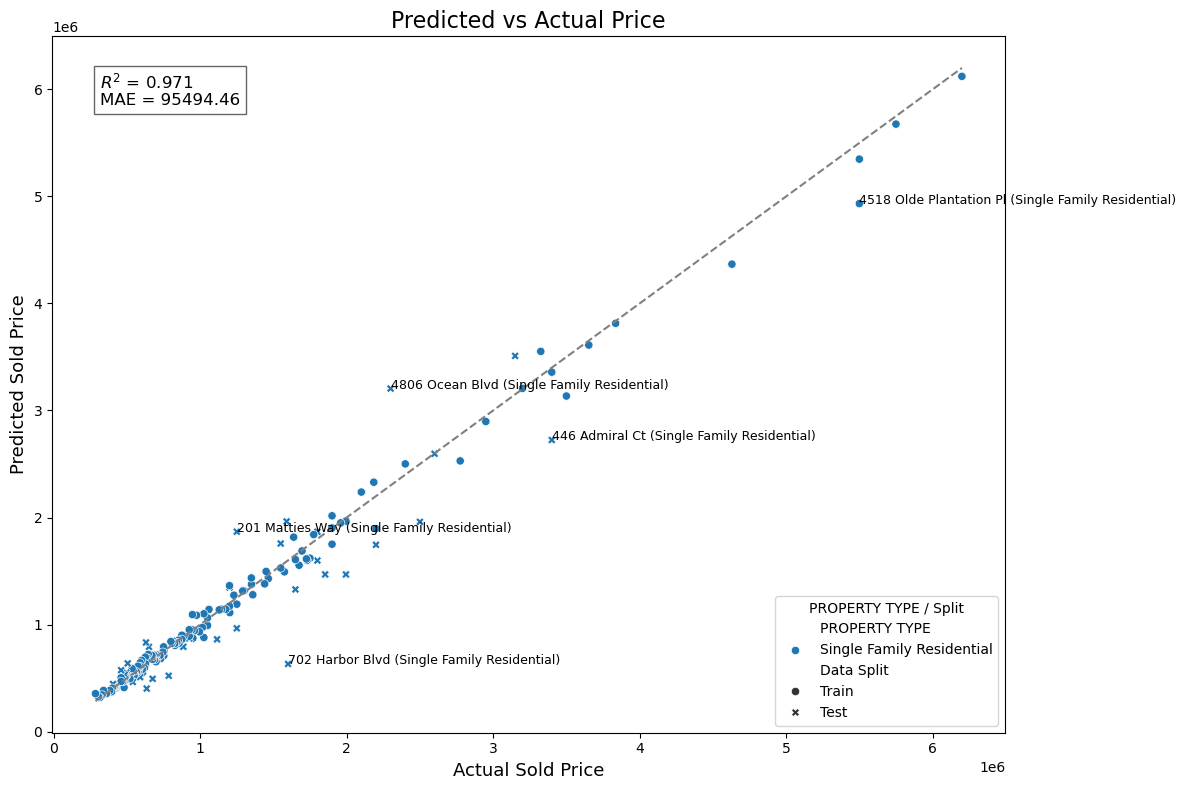

In [462]:
# Calculate metrics
r2 = r2_score(all_predictions['PRICE'], all_predictions['PredictedPrice'])
mae = mean_absolute_error(all_predictions['PRICE'], all_predictions['PredictedPrice'])

# Calculate residuals
all_predictions['Residual'] = np.abs(all_predictions['PRICE'] - all_predictions['PredictedPrice'])

# Get top 5 outliers
top_outliers = all_predictions.nlargest(5, 'Residual')

# Plotting
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=all_predictions,
    x='PRICE',
    y='PredictedPrice',
    hue='PROPERTY TYPE',
    style='Data Split',
    palette='tab10',
)

# Diagonal line for reference (perfect prediction)
min_val = min(all_predictions['PRICE'].min(), all_predictions['PredictedPrice'].min())
max_val = max(all_predictions['PRICE'].max(), all_predictions['PredictedPrice'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color='gray')

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['PRICE'] + 2, row['PredictedPrice'],
             f"{row['ADDRESS']} ({row['PROPERTY TYPE']})", fontsize=9, color='black')

# Labels and title
plt.title('Predicted vs Actual Price', fontsize=16)
plt.xlabel('Actual Sold Price', fontsize=13)
plt.ylabel('Predicted Sold Price', fontsize=13)

# Get the current axes
ax = plt.gca()

# Display R² and MAE in the top left using axes coordinates
plt.text(0.05, 0.95,  # Top left corner
         f"$R^2$ = {r2:.3f}\nMAE = {mae:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6),
         transform=ax.transAxes,  # Use axes coordinates
         verticalalignment='top', horizontalalignment='left')

# Legend and layout
plt.legend(title='PROPERTY TYPE / Split', loc='lower right')
plt.tight_layout()
plt.show()

In [464]:
all_predictions['ValuationDiff'] = all_predictions['PredictedPrice'] - all_predictions['PRICE']

In [466]:
overvalued = all_predictions.sort_values(by='ValuationDiff', ascending=False).head(10)
print("Most Over-Valued Properties:")
print(overvalued[['ADDRESS', 'Data Split', 'PROPERTY TYPE', 'PRICE', 'PredictedPrice', 'ValuationDiff']])

Most Over-Valued Properties:
                ADDRESS Data Split              PROPERTY TYPE    PRICE  \
18      4806 Ocean Blvd       Test  Single Family Residential  2300000   
55      201 Matties Way       Test  Single Family Residential  1250000   
42     4657 Destiny Way       Test  Single Family Residential  1590000   
12    4548 Sailmaker Ln       Test  Single Family Residential  3150000   
10      4713 Ocean Blvd      Train  Single Family Residential  3325000   
45       262 Lantern Ln       Test  Single Family Residential  1549700   
115        66 Garnet Pl       Test  Single Family Residential   630000   
40     3610 Melrose Ave      Train  Single Family Residential  1638000   
61      609 Calhoun Ave      Train  Single Family Residential  1200000   
60   90 Terra Cotta Way       Test  Single Family Residential  1200000   

     PredictedPrice  ValuationDiff  
18        3204840.0       904840.0  
55        1867782.0       617782.0  
42        1963546.0       373546.0  
12      

In [468]:
undervalued = all_predictions.sort_values(by='ValuationDiff').head(10)
print("Most Under-Valued Properties:")
print(undervalued[['ADDRESS', 'Data Split', 'PROPERTY TYPE', 'PRICE', 'PredictedPrice', 'ValuationDiff']])

Most Under-Valued Properties:
                    ADDRESS Data Split              PROPERTY TYPE    PRICE  \
41          702 Harbor Blvd       Test  Single Family Residential  1600000   
9            446 Admiral Ct       Test  Single Family Residential  3400000   
2   4518 Olde Plantation Pl      Train  Single Family Residential  5500000   
16            103 Shirah St       Test  Single Family Residential  2500000   
24          722 Harbor Blvd       Test  Single Family Residential  1995000   
19           20 Norriego Rd       Test  Single Family Residential  2200000   
29      4316 Stonebridge Rd       Test  Single Family Residential  1853000   
7           4748 ocean Blvd      Train  Single Family Residential  3500000   
38          4821 Ocean Blvd       Test  Single Family Residential  1650000   
20               5 Cross Ct      Train  Single Family Residential  2200000   

    PredictedPrice  ValuationDiff  
41        631672.0      -968328.0  
9        2724162.0      -675838.0  
2  

### XGBoost with Cross Validation and optimate boosting rounds for early stoppage
* This script trains an XGBoost regression model for each valid property type 
in the Redfin dataset using k-fold cross-validation (default: 5 folds). 
It selects the optimal number of boosting rounds using early stopping 
based on MAE, fits the final model, and outputs predictions along with 
feature importance per property type.

In [471]:
import xgboost as xgb

# Define XGBoost hyperparameters
xgb_params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Function to train and predict with log-transformed target
def train_and_predict_cv(property_type, features, n_folds=5):
    property_data = df[df['PROPERTY TYPE'] == property_type].copy()
    if property_data.empty:
        print(f"No data found for PROPERTY TYPE: {property_type}")
        return pd.DataFrame()

    X = property_data[features].fillna(0).reset_index(drop=True)
    
    # Step 1: Log-transform the target
    y_log = np.log1p(property_data['PRICE'].fillna(0)).reset_index(drop=True)
    
    property_data = property_data.reset_index(drop=True)
    dmatrix = xgb.DMatrix(data=X, label=y_log, feature_names=features)

    # Cross-validation to determine optimal boosting rounds
    cv_results = xgb.cv(
        params=xgb_params,
        dtrain=dmatrix,
        num_boost_round=150,
        nfold=n_folds,
        metrics='mae',
        early_stopping_rounds=10,
        verbose_eval=False,
        seed=42
    )

    best_n_rounds = cv_results['test-mae-mean'].idxmin()
    best_log_mae = cv_results['test-mae-mean'].min()
    print(f"{property_type} - Best MAE (log scale): {best_log_mae:.4f} at {best_n_rounds} rounds")

    # Final model training on full log-transformed data
    final_model = xgb.train(params=xgb_params, dtrain=dmatrix, num_boost_round=best_n_rounds)

    # Step 2: Predict in log space, then reverse the transformation
    preds_log = final_model.predict(dmatrix)
    preds_original = np.expm1(preds_log)  # reverse log1p

    property_data['PredictedPrice'] = preds_original
    property_data['Data Split'] = 'CV'

    # Feature importance
    importance_dict = final_model.get_score(importance_type='gain')
    if importance_dict:
        importance_df = pd.DataFrame({
            'Feature': list(importance_dict.keys()),
            'Importance': list(importance_dict.values()),
            'PropertyType': property_type
        }).sort_values(by='Importance', ascending=False).reset_index(drop=True)
        total = importance_df['Importance'].sum()
        importance_df['NormalizedImportance'] = importance_df['Importance'] / total * 100

        print(f"\n{property_type} - Feature Importances:")
        print(importance_df)
    else:
        print(f"\n{property_type} - No feature importance (likely due to 0 boosting rounds).")

    return property_data[['ADDRESS', 'Data Split', 'PROPERTY TYPE', 'PredictedPrice', 'PRICE']]

# Feature columns to use
features = ['BEDS', 'BATHS', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT', 'Waterfront',
            'Privatepool', 'HOA/MONTH', 'LATITUDE', 'LONGITUDE', 'ZIP OR POSTAL CODE']

# Filter property types with at least 2 listings
valid_types = df['PROPERTY TYPE'].value_counts()
valid_types = valid_types[valid_types >= 2].index

# Run model for each property type
all_predictions_list = []

for property_type in valid_types:
    prediction_df = train_and_predict_cv(property_type, features, n_folds=5)
    if not prediction_df.empty:
        all_predictions_list.append(prediction_df)

# Combine and round predictions
all_predictions = pd.concat(all_predictions_list, ignore_index=True).round(0)

# Export to CSV
output_path = "Data/Redfin_PropertyType_XGB_CV_Best.csv"
all_predictions[['ADDRESS', 'Data Split', 'PROPERTY TYPE', 'PredictedPrice', 'PRICE']].to_csv(output_path, index=False)

Single Family Residential - Best MAE (log scale): 0.2098 at 80 rounds

Single Family Residential - Feature Importances:
       Feature  Importance               PropertyType  NormalizedImportance
0        BATHS    2.967310  Single Family Residential             38.730389
1  SQUARE FEET    1.463715  Single Family Residential             19.104926
2   Waterfront    1.128126  Single Family Residential             14.724699
3  Privatepool    0.818555  Single Family Residential             10.684071
4     LATITUDE    0.408789  Single Family Residential              5.335655
5    HOA/MONTH    0.234733  Single Family Residential              3.063822
6   YEAR BUILT    0.185545  Single Family Residential              2.421794
7    LONGITUDE    0.170536  Single Family Residential              2.225895
8     LOT SIZE    0.164605  Single Family Residential              2.148478
9         BEDS    0.119539  Single Family Residential              1.560271


In [385]:
# Evaluate R² and MAE by position
# We start with an empty list that then becomes a list of data dictionaries
position_metrics = []

for pos in all_predictions['PROPERTY TYPE'].unique():
    subset = all_predictions[all_predictions['PROPERTY TYPE'] == pos]
    r2 = r2_score(subset['PRICE'], subset['PredictedPrice'])
    mae = mean_absolute_error(subset['PRICE'], subset['PredictedPrice'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nPerformance Metrics by Position:")
print(position_metrics_df)


Performance Metrics by Position:
                    Position     R²       MAE
0  Single Family Residential  0.978  98796.86


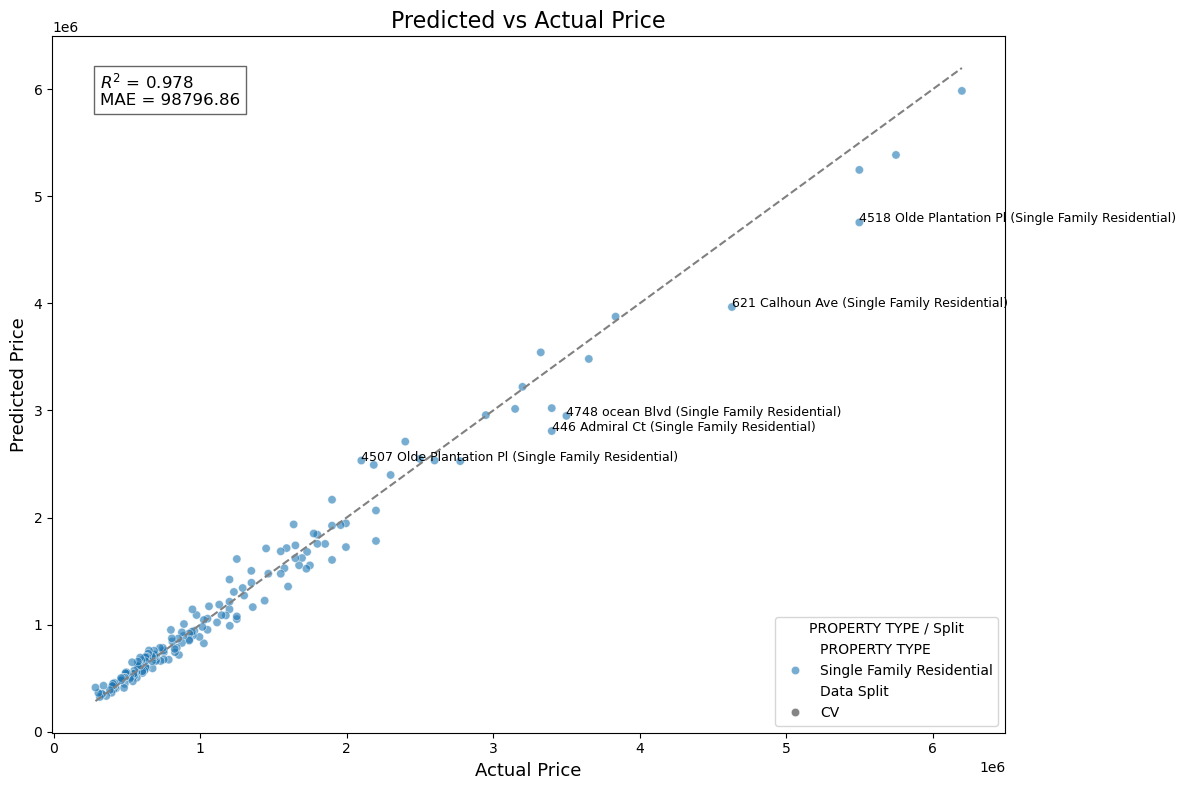

In [387]:
# Calculate metrics
r2 = r2_score(all_predictions['PRICE'], all_predictions['PredictedPrice'])
mae = mean_absolute_error(all_predictions['PRICE'], all_predictions['PredictedPrice'])

# Calculate residuals
all_predictions['Residual'] = np.abs(all_predictions['PRICE'] - all_predictions['PredictedPrice'])

# Get top 5 outliers
top_outliers = all_predictions.nlargest(5, 'Residual')

# Plotting
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=all_predictions,
    x='PRICE',
    y='PredictedPrice',
    hue='PROPERTY TYPE',
    style='Data Split',
    palette='tab10',
    alpha=0.6
)

# Diagonal line for reference (perfect prediction)
min_val = min(all_predictions['PRICE'].min(), all_predictions['PredictedPrice'].min())
max_val = max(all_predictions['PRICE'].max(), all_predictions['PredictedPrice'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color='gray')

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['PRICE'] + 2, row['PredictedPrice'],
             f"{row['ADDRESS']} ({row['PROPERTY TYPE']})", fontsize=9, color='black')

# Labels and title
plt.title('Predicted vs Actual Price', fontsize=16)
plt.xlabel('Actual Price', fontsize=13)
plt.ylabel('Predicted Price', fontsize=13)

# Get the current axes
ax = plt.gca()

# Display R² and MAE in the top left using axes coordinates
plt.text(0.05, 0.95,  # Top left corner
         f"$R^2$ = {r2:.3f}\nMAE = {mae:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6),
         transform=ax.transAxes,  # Use axes coordinates
         verticalalignment='top', horizontalalignment='left')

# Legend and layout
plt.legend(title='PROPERTY TYPE / Split', loc='lower right')
plt.tight_layout()
plt.show()

In [389]:
all_predictions['ValuationDiff'] = all_predictions['PredictedPrice'] - all_predictions['PRICE']

In [391]:
overvalued = all_predictions.sort_values(by='ValuationDiff', ascending=False).head(10)
print("Most Over-Valued Properties:")
print(overvalued[['ADDRESS', 'Data Split', 'PROPERTY TYPE', 'PRICE', 'PredictedPrice', 'ValuationDiff']])

Most Over-Valued Properties:
                    ADDRESS Data Split              PROPERTY TYPE    PRICE  \
22  4507 Olde Plantation Pl         CV  Single Family Residential  2100000   
55          201 Matties Way         CV  Single Family Residential  1250000   
17       4659 Westwinds Way         CV  Single Family Residential  2400000   
21     499 Regatta Bay Blvd         CV  Single Family Residential  2185000   
40         3610 Melrose Ave         CV  Single Family Residential  1638000   
26       4616 Paradise Isle         CV  Single Family Residential  1900000   
47          248 Matties Way         CV  Single Family Residential  1450000   
61          609 Calhoun Ave         CV  Single Family Residential  1200000   
10          4713 Ocean Blvd         CV  Single Family Residential  3325000   
76             92 Cayman Cv         CV  Single Family Residential   947000   

    PredictedPrice  ValuationDiff  
22       2532253.0       432253.0  
55       1612123.0       362123.0  
17  

In [393]:
undervalued = all_predictions.sort_values(by='ValuationDiff').head(10)
print("Most Under-Valued Properties:")
print(undervalued[['ADDRESS', 'Data Split', 'PROPERTY TYPE', 'PRICE', 'PredictedPrice', 'ValuationDiff']])

Most Under-Valued Properties:
                    ADDRESS Data Split              PROPERTY TYPE    PRICE  \
2   4518 Olde Plantation Pl         CV  Single Family Residential  5500000   
4           621 Calhoun Ave         CV  Single Family Residential  4630000   
9            446 Admiral Ct         CV  Single Family Residential  3400000   
7           4748 ocean Blvd         CV  Single Family Residential  3500000   
20               5 Cross Ct         CV  Single Family Residential  2200000   
8    3484 Scenic Highway 98         CV  Single Family Residential  3400000   
1            85 Woodward St         CV  Single Family Residential  5750000   
27       4630 Paradise Isle         CV  Single Family Residential  1900000   
24          722 Harbor Blvd         CV  Single Family Residential  1995000   
3            400 Coleman Pt         CV  Single Family Residential  5500000   

    PredictedPrice  ValuationDiff  
2        4757036.0      -742964.0  
4        3966896.0      -663104.0  
9  

### Adding new listing data to the CrossValidation Best Boosting Rounds Example

In [403]:
import xgboost as xgb

# Define XGBoost hyperparameters
xgb_params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Feature columns to use
features = [
    'BEDS', 'BATHS', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT',
    'Waterfront', 'Privatepool', 'HOA/MONTH', 'LATITUDE', 'LONGITUDE', 'ZIP OR POSTAL CODE'
]

# Load datasets
df = pd.read_csv("Data/RedfinDataReadyData3.csv")
df_test = pd.read_csv("Data/Redfin_NewListings.csv")

# --------------------------
# Training and CV Function
# --------------------------
def train_and_predict_cv(property_type, features, n_folds=5):
    property_data = df[df['PROPERTY TYPE'] == property_type].copy()
    if property_data.empty:
        print(f"No data found for PROPERTY TYPE: {property_type}")
        return pd.DataFrame(), None

    X = property_data[features].fillna(0).reset_index(drop=True)
    y = np.log1p(property_data['PRICE'].fillna(0).reset_index(drop=True))  # <-- Log transform
    property_data = property_data.reset_index(drop=True)
    
    dmatrix = xgb.DMatrix(data=X, label=y, feature_names=features)

    # Cross-validation to find best number of boosting rounds
    cv_results = xgb.cv(
        params=xgb_params,
        dtrain=dmatrix,
        num_boost_round=150,
        nfold=n_folds,
        metrics='mae',
        early_stopping_rounds=10,
        verbose_eval=False,
        seed=42
    )

    best_n_rounds = cv_results['test-mae-mean'].idxmin()
    best_mae = cv_results['test-mae-mean'].min()
    print(f"{property_type} - Best MAE (log-scale): {best_mae:.4f} at {best_n_rounds} rounds")

    # Train final model
    final_model = xgb.train(params=xgb_params, dtrain=dmatrix, num_boost_round=best_n_rounds)
    
    preds_log = final_model.predict(dmatrix)
    property_data['PredictedPrice'] = np.expm1(preds_log)  # <-- Convert back to dollar scale
    property_data['Data Split'] = 'CV'

    # Feature importance with boosting applied
    importance_dict = final_model.get_score(importance_type='gain') or {}

    if importance_dict:
        importance_df = pd.DataFrame({
            'Feature': list(importance_dict.keys()),
            'Importance': list(importance_dict.values()),
            'PropertyType': property_type
        })

        # Boost importance of 'Waterfront' and 'YEAR BUILT'
        importance_df.loc[importance_df['Feature'].isin(['Waterfront', 'SQUARE FEET']), 'Importance'] *= 2

        # Normalize and sort
        total = importance_df['Importance'].sum()
        importance_df['NormalizedImportance'] = importance_df['Importance'] / total * 100
        importance_df = importance_df.sort_values(by='NormalizedImportance', ascending=False).reset_index(drop=True)

        print(f"\n{property_type} - Feature Importances (Boosted):")
        print(importance_df)
    else:
        print(f"\n{property_type} - No feature importance (likely due to 0 boosting rounds or unused features).")

    return property_data[['ADDRESS', 'Data Split', 'PROPERTY TYPE', 'PredictedPrice', 'PRICE']], final_model

# --------------------------
# Prediction on New Data
# --------------------------
def apply_model_to_new_data(test_data, model, features):
    X_test = test_data[features].fillna(0).reset_index(drop=True)
    dmatrix_test = xgb.DMatrix(data=X_test, feature_names=features)
    test_data = test_data.reset_index(drop=True)

    preds_log = model.predict(dmatrix_test)
    test_data['PredictedPrice'] = np.expm1(preds_log)  # <-- Convert back to dollar scale
    test_data['Data Split'] = 'Test'

    return test_data[['ADDRESS', 'Data Split', 'PROPERTY TYPE', 'PredictedPrice']]

# --------------------------
# Loop Through Property Types
# --------------------------
valid_types = df['PROPERTY TYPE'].value_counts()
valid_types = valid_types[valid_types >= 2].index

all_predictions_list = []
test_predictions_list = []

for property_type in valid_types:
    prediction_df, trained_model = train_and_predict_cv(property_type, features, n_folds=5)
    if not prediction_df.empty:
        all_predictions_list.append(prediction_df)

    test_subset = df_test[df_test['PROPERTY TYPE'] == property_type]
    if not test_subset.empty and trained_model is not None:
        predicted_test = apply_model_to_new_data(test_subset, trained_model, features)
        test_predictions_list.append(predicted_test)

# --------------------------
# Combine and Export Results
# --------------------------
all_predictions = pd.concat(all_predictions_list, ignore_index=True).round(0)
test_predictions = pd.concat(test_predictions_list, ignore_index=True).round(0)

# Save to CSV (no index column)
all_predictions.to_csv("Data/Redfin_PropertyType_XGB_CV.csv", index=False)
test_predictions.to_csv("Data/Redfin_NewListings_Predicted.csv", index=False)

Single Family Residential - Best MAE (log-scale): 0.2134 at 64 rounds

Single Family Residential - Feature Importances (Boosted):
       Feature  Importance               PropertyType  NormalizedImportance
0        BATHS    1.493784  Single Family Residential             33.447611
1   Waterfront    1.160756  Single Family Residential             25.990725
2  SQUARE FEET    1.042697  Single Family Residential             23.347226
3     LATITUDE    0.207597  Single Family Residential              4.648343
4  Privatepool    0.201199  Single Family Residential              4.505088
5    HOA/MONTH    0.112646  Single Family Residential              2.522283
6    LONGITUDE    0.080750  Single Family Residential              1.808094
7   YEAR BUILT    0.071884  Single Family Residential              1.609572
8     LOT SIZE    0.057356  Single Family Residential              1.284270
9         BEDS    0.037371  Single Family Residential              0.836789


* Listings predicted lower than predicted sold price: These may be underpriced in the current market, suggesting a possible bidding war or pricing strategy opportunity.

* Listings predicted higher than predicted sold price: These may be overpriced and could face resistance or longer time on market.

* Equal predictions (num_equal): Model aligns with agent pricing — potentially priced correctly.

